# Project 3 MVE441

### Theme 2c

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import numpy as np
from skimage import transform

In [18]:
# Read the features file
cats_N_dogs_features = pd.read_csv("CATSnDOGS.csv", delimiter=',').dropna(axis=1).to_numpy()

# Read the labels file
cats_N_dogs_labels = pd.read_csv("Labels.csv", delimiter=',').dropna(axis=1).to_numpy().ravel()

# Edit misslabeled pictures
mislabel_indices = [8, 112, 12, 177, 37, 26, 114, 54, 151, 117, 176]
for index in mislabel_indices:
    cats_N_dogs_labels[index] = 1 * (1 - cats_N_dogs_labels[index])

# Rescale data
cats_N_dogs_features = StandardScaler().fit_transform(cats_N_dogs_features)


In [19]:
import matplotlib.pyplot as plt

In [20]:
def reshape_picture_array(image):
    image_resolution = int(np.sqrt(len(image)))
    # Extract image data from the row
    image = np.array(image).reshape((image_resolution, image_resolution))
    return image

In [21]:
def plot_grayscale_image(row):
    image_resolution = int(np.sqrt(len(row)))
    # Extract image data from the row
    image_data = reshape_picture_array(row).T  # Assuming the image data is stored in a 1D array and represents a 28x28 image
    # Plot the grayscale image
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.title('Grayscale Image')
    plt.show()

In [22]:

augmented_images = np.zeros(cats_N_dogs_features.shape)
augmented_labels = np.zeros(cats_N_dogs_labels.shape)

i=0
#Rotate every other picture.
for image, label in zip(cats_N_dogs_features, cats_N_dogs_labels):
    if i % 2 == 0:
        reshaped_image = reshape_picture_array(image)
        
        # Rotate image by 90 degrees
        rotated_image = transform.rotate(reshaped_image, angle=180, resize=False)
        augmented_images[i,:] = rotated_image.flatten()
        augmented_labels[i] = int(label)
    else:
        augmented_images[i,:] = image.flatten()
        augmented_labels[i] = int(label)
    i=i+1
    
    

In [23]:
# Rotate every other picture.

def augment_images(features, labels):
    augmented_images = np.zeros(features.shape)
    augmented_labels = np.zeros(labels.shape)

    i=0
    for image, label in zip(features, labels):
        if i % 2 == 0:
            reshaped_image = reshape_picture_array(image)
            # Rotate image by 90 degrees
            rotated_image = transform.rotate(reshaped_image, angle=180, resize=False)
            augmented_images[i,:] = rotated_image.flatten()
            augmented_labels[i] = int(label)
        else:
            augmented_images[i,:] = image.flatten()
            augmented_labels[i] = int(label)
        i=i+1
    return augmented_images, augmented_labels

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [25]:
# Evaluate regularisation parameter.
lasso_performance = []
for iter in np.arange(1,20, 1):
    X_train, X_test, y_train, y_test = train_test_split(cats_N_dogs_features,cats_N_dogs_labels, test_size=0.3)
    X_train, y_train = augment_images(X_train, y_train)
    X_test, y_test = augment_images(X_test, y_test)
    scores = []
    for C in np.arange(0.01,1,0.05):
        scores.append(C)
        lasso = LogisticRegression(C=C, max_iter=1000)
        lasso.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, lasso.predict(X_test)))
        scores.append(f1_score(y_test, lasso.predict(X_test), average='macro'))
    lasso_performance.append(scores)

In [26]:
#Plot performance of lasso classifier
def plot_metrics(performance_array, x_axis, y_axis, title):
    x_values = [x[0] for x in performance_array]
    accuracy = [x[1] for x in performance_array]
    f1 = [x[2] for x in performance_array]
    
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    
    plt.plot(x_values, accuracy, label ='Accuracy')
    plt.plot(x_values, f1, label='F1 score')
    plt.legend(loc="upper left")

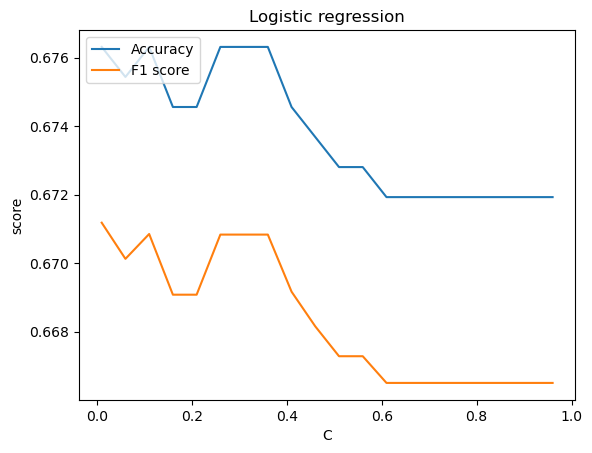

In [27]:
lasso_performance = np.array(lasso_performance)
lasso_performance_1 = np.mean(lasso_performance, axis=0).reshape(-1,3)
plot_metrics(lasso_performance_1,"C", "score", "Logistic regression")
accuracy = [element[1] for element in lasso_performance]
max_index = np.argmax(accuracy)
#print(lasso_performance[max_index])

In [28]:
# Extract feature importance and classification bias.
def evaluate_classification(model, model_type):

    number_of_labels = len(augmented_labels)
    indices = np.arange(number_of_labels)
    feature_importance = np.zeros(augmented_images[0].shape)
    number_of_iterations = range(0, 100)
    
    classification_accuracy_usd = []
    classification_accuracy_rsu = []
    for iteration in number_of_iterations:
        # Split the data using the indices
        '''
        train_indices, test_indices = train_test_split(indices, test_size=0.3)
        X_train, X_test = augmented_images[train_indices], augmented_images[test_indices]
        y_train, y_test = augmented_labels[train_indices], augmented_labels[test_indices]
        model.fit(X_train, y_train)
        '''
        X_train, X_test, y_train, y_test = train_test_split(cats_N_dogs_features,cats_N_dogs_labels, test_size=0.3)
        X_train, y_train = augment_images(X_train, y_train)
        X_test, y_test = augment_images(X_test, y_test)
        model.fit(X_train, y_train)
        
        if model_type == 'linear':
            feature_importance = feature_importance + abs(model.coef_.flatten())
        else:
            feature_importance = feature_importance + model.feature_importances_
            
        usd_indexes = [index % 2 == 0 for index in range(len(y_test))]
        rsu_indexes = [index % 2 != 0 for index in range(len(y_test))]
        model_predictions_rsu = model.predict(X_test[rsu_indexes])
        model_predictions_usd = model.predict(X_test[usd_indexes])
        classification_accuracy_rsu.append(accuracy_score(y_test[rsu_indexes], model_predictions_rsu))
        classification_accuracy_usd.append(accuracy_score(y_test[usd_indexes], model_predictions_usd))
        
    return feature_importance, np.array(classification_accuracy_rsu).flatten(), np.array(classification_accuracy_usd).flatten()

In [29]:
def plot_grayscale_importance_image(row, coefficients):
    image_resolution = int(np.sqrt(len(row)))
    # Extract image data from the row
    image_data = reshape_picture_array(row).T  # Assuming the image data is stored in a 1D array and represents a 28x28 image
    coefficients = reshape_picture_array(coefficients).T
   
    # Plot the grayscale image
    plt.imshow(image_data, cmap='gray')
    plt.imshow(coefficients, cmap='hot', alpha=0.5)
    
    
    plt.axis('off')  # Turn off axis
    plt.show()

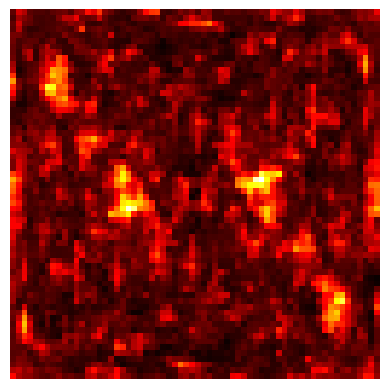

In [30]:
# plot heatmap of feature importance
feature_importance_logistic, accuracy_rsu_logistic ,accuracy_usd_logistic  = evaluate_classification(LogisticRegression(C=0.02), "linear")
reshaped_features = reshape_picture_array(feature_importance_logistic).T
plt.imshow(reshaped_features, cmap='hot')
plt.axis('off') 
plt.show()



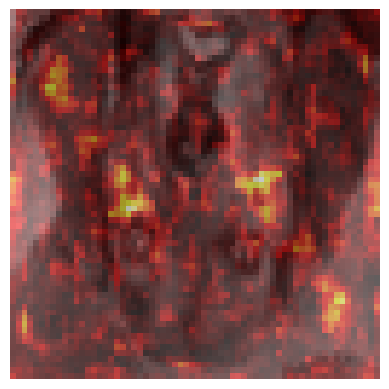

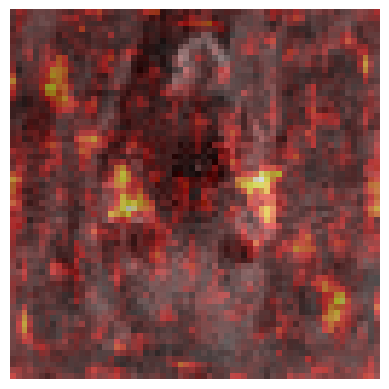

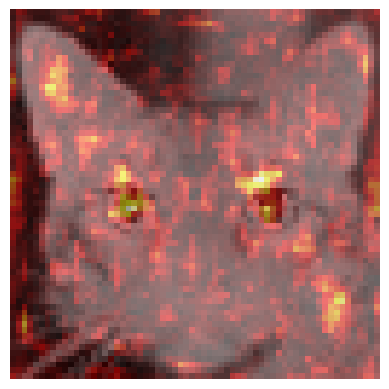

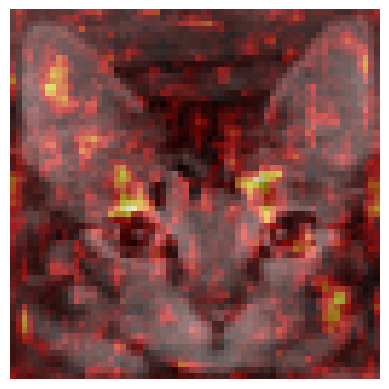

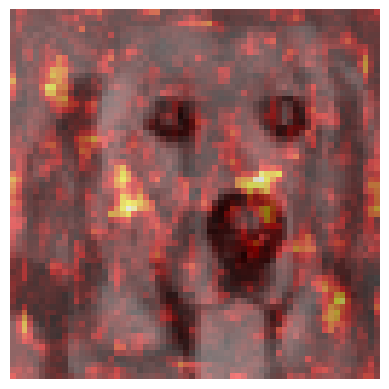

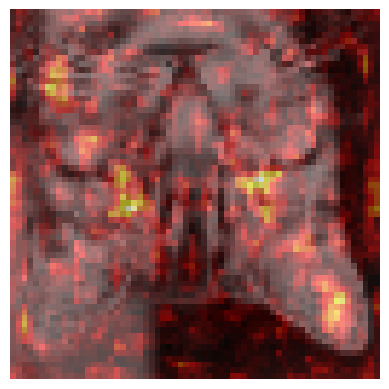

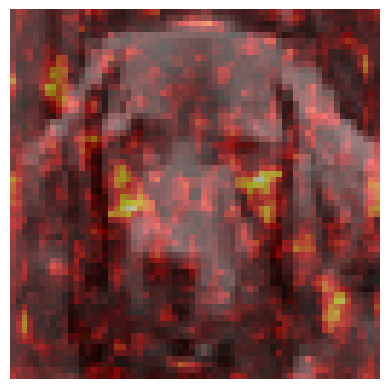

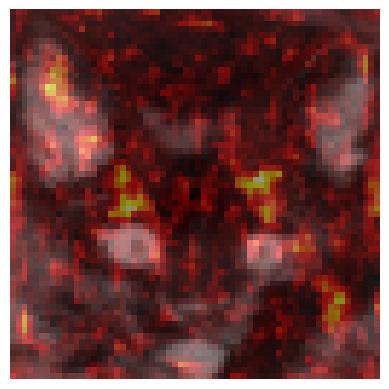

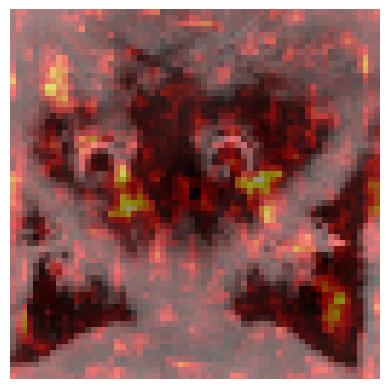

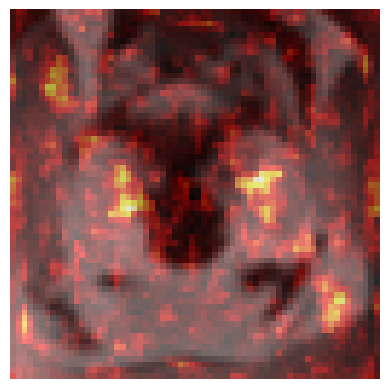

In [31]:
for i in np.random.randint(0, 100, size=10):
    plot_grayscale_importance_image(augmented_images[i], feature_importance_logistic)

It is apparent that the logistic regression model predominantly focuses on the regions corresponding to the eyes and the left ear in the image. The highlighted features exhibit a bias towards the cat, which aligns with expectations given that cats typically exhibit greater homogeneity in their morphological characteristics.



In [47]:
def plot_model_accuracy(accuracy_rsu, accuracy_usd, model_name):
    
    iterations = np.arange(1, len(accuracy_rsu) + 1)

    # Plot the accuracy scores
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, accuracy_rsu, marker='o', label= model_name + ' right side up')
    plt.plot(iterations, accuracy_usd, marker='o', label= model_name + ' upside down')

    # Add title and labels
    plt.title('Accuracy Scores Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, 100, 10))
    # Set x-axis ticks to be the iteration numbers
    plt.legend()

    # Show plot
    plt.show()

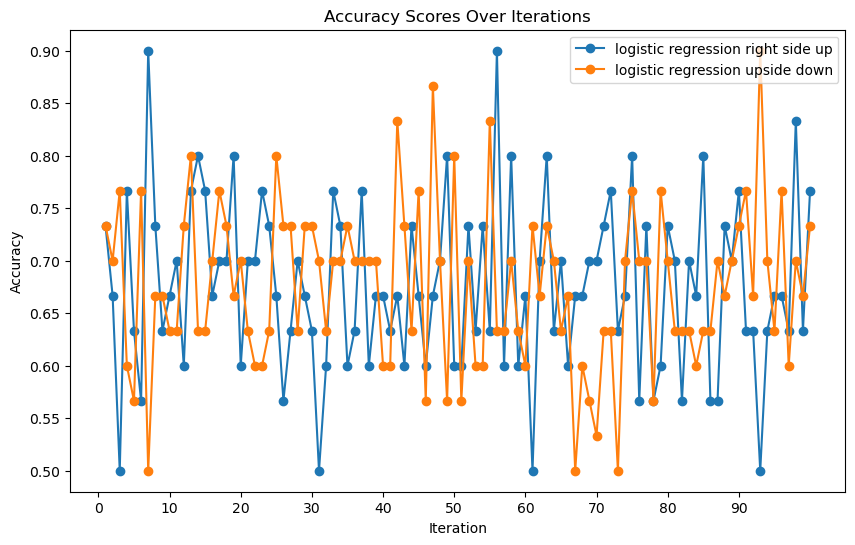

0.6756666666666667
0.6759999999999999


In [48]:
plot_model_accuracy(accuracy_rsu_logistic, accuracy_usd_logistic, "logistic regression")
print(np.mean(accuracy_usd_logistic))
print(np.mean(accuracy_rsu_logistic))

Based on the logistic regression model's performance, there appears to be no significant bias towards classifying images as upside down or right side up. This lack of bias is likely due to the extensive resampling of the dataset, which was performed 100 times to ensure robustness and generalization of the model.

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import seaborn as sns

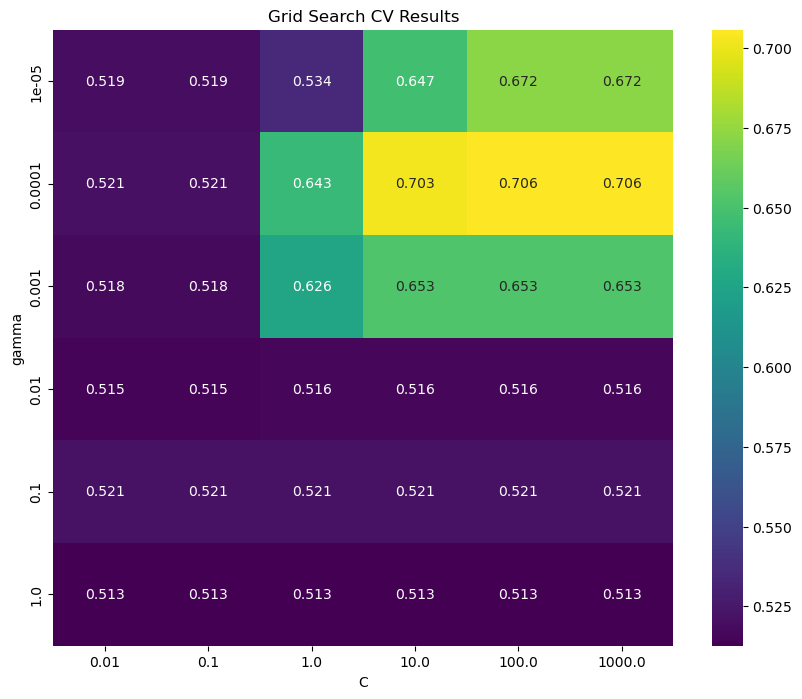

In [35]:
# Gridsearch for SVC
pivot_tables = []
for iter in np.arange(1,20,1):
    X_train, X_test, y_train, y_test = train_test_split(cats_N_dogs_features,cats_N_dogs_labels, test_size=0.3)
    X_train, y_train = augment_images(X_train, y_train)
    X_test, y_test = augment_images(X_test, y_test)
    param_grid= {'C': [0.01, 0.1, 1, 10, 100, 1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}

    svc = SVC()
    grid_search = GridSearchCV(svc, param_grid, cv = 5)
    grid_search.fit(X_train, y_train)

    results_df = pd.DataFrame(grid_search.cv_results_)
    scores_df = results_df[['param_C', 'param_gamma', 'mean_test_score']]
    pivot_tables.append(scores_df.pivot_table(index='param_gamma', columns='param_C', values='mean_test_score'))

sum_pivot_table = sum(pivot_tables)

# Compute the average
average_pivot_table = sum_pivot_table / len(pivot_tables)
plt.figure(figsize=(10, 8))
sns.heatmap(average_pivot_table, annot=True, fmt=".3f", cmap="viridis")
plt.title('Grid Search CV Results')
plt.xlabel('C')
plt.ylabel('gamma')
plt.show()



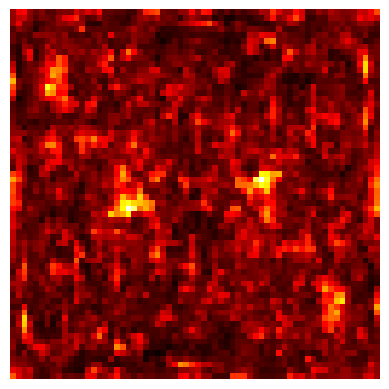

In [36]:
# Plot heatmap of feature importance
feature_importance_SVC, accuracy_rsu_SVC ,accuracy_usd_SVC = evaluate_classification(SVC(kernel='linear', C=10, gamma=0.0001), "linear")
reshaped_features = reshape_picture_array(feature_importance_SVC).T
plt.imshow(reshaped_features, cmap='hot')
plt.axis('off') 
plt.show()


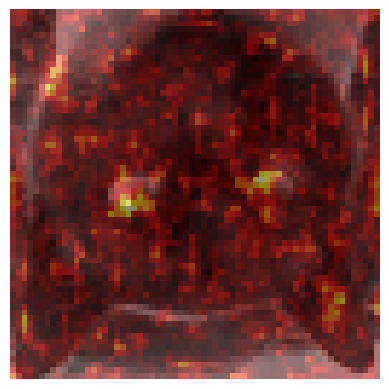

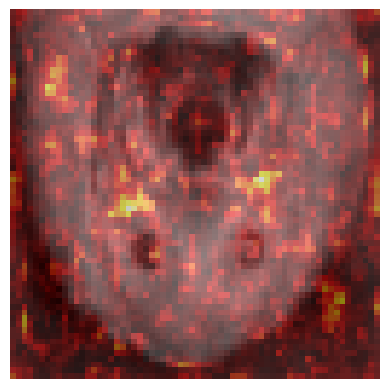

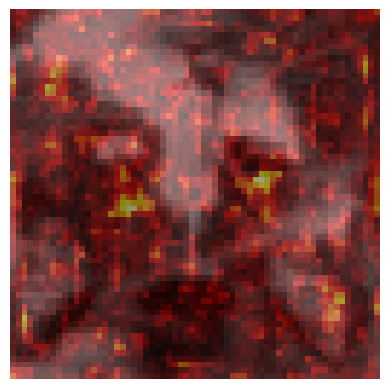

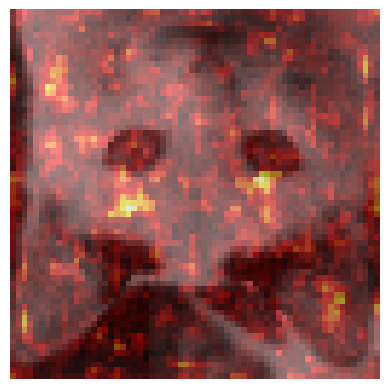

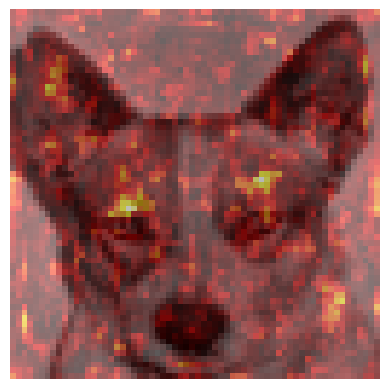

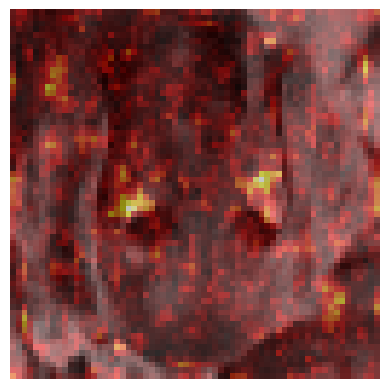

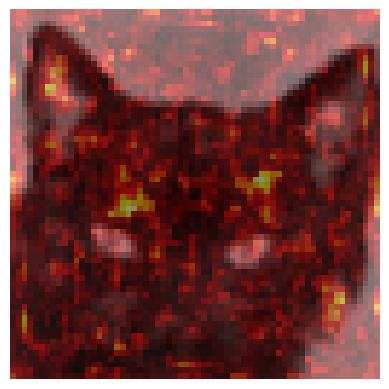

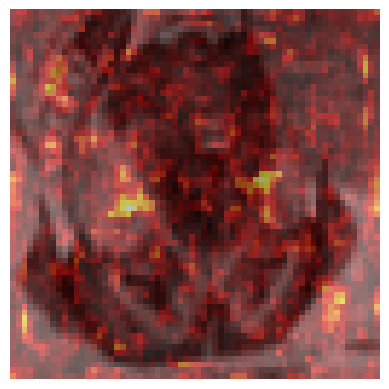

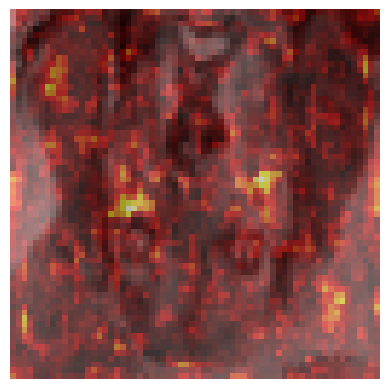

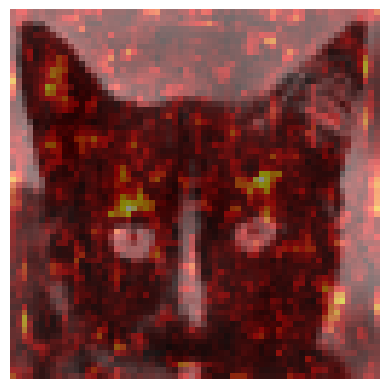

In [37]:
for i in np.random.randint(0, 100, size=10):
    plot_grayscale_importance_image(augmented_images[i], feature_importance_SVC)

It is evident that the SVC with a linear kernel primarily focuses on regions such as the eyes and the left ear in the image. Similar to logistic regression, the highlighted features demonstrate a bias towards the cat, which is consistent with the anticipated homogeneity in feline morphological characteristics.

Interestingly, despite employing a different regularization method, the observed classification results were not significantly impacted.

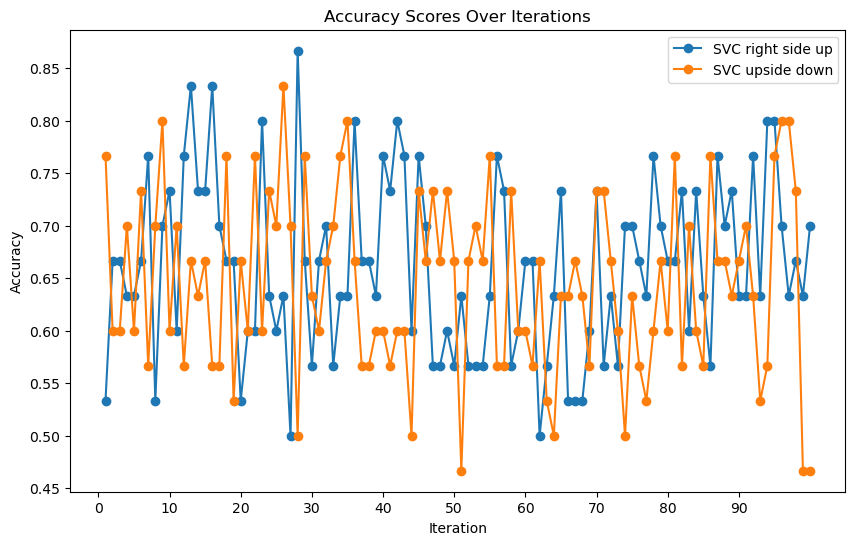

0.6446666666666667
0.6613333333333334


In [50]:
# Plot accuracy bias
plot_model_accuracy(accuracy_rsu_SVC, accuracy_usd_SVC, "SVC")
print(np.mean(accuracy_usd_SVC))
print(np.mean(accuracy_rsu_SVC))

Upon analyzing the performance of the Support Vector Classifier (SVC), no discernible bias is evident in classifying images as either upside down or right side up. This observation underscores the robustness of the model, achieved through the resampling of the dataset 100 times. By iteratively training on varied subsets of data, the SVC ensures a comprehensive understanding of the image features, leading to reliable and generalized classifications.



In [39]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostClassifier

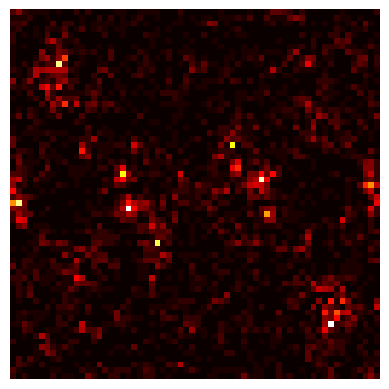

In [40]:
# Plot heatmap of feature importance
feature_importance_ada, accuracy_rsu_ada ,accuracy_usd_ada = evaluate_classification(AdaBoostClassifier(),None)
reshaped_features = reshape_picture_array(feature_importance_ada).T
plt.imshow(reshaped_features, cmap='hot')
plt.axis('off') 
plt.show()

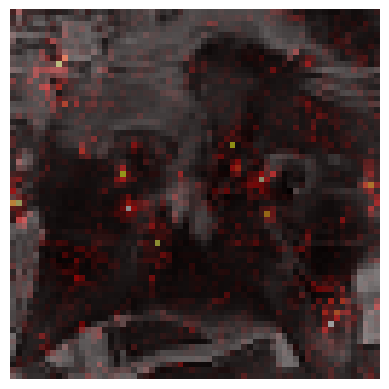

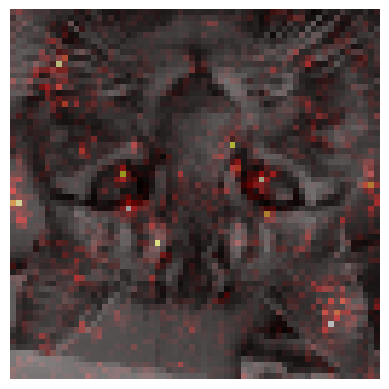

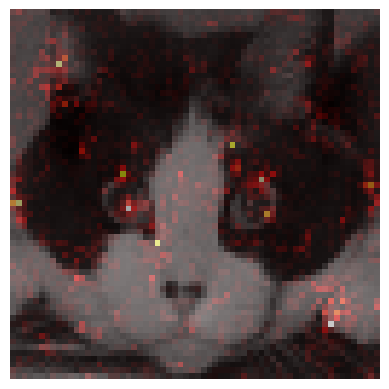

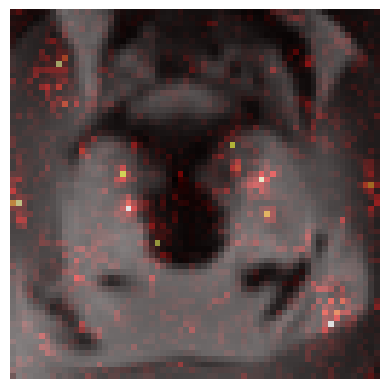

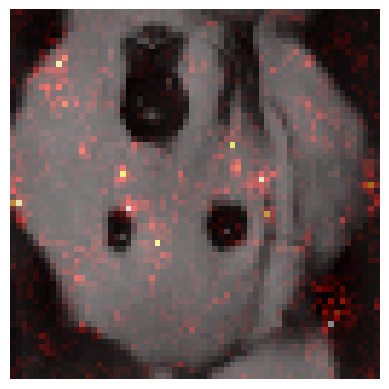

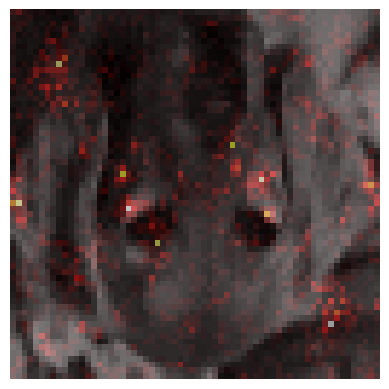

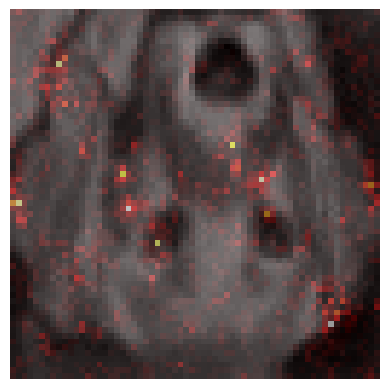

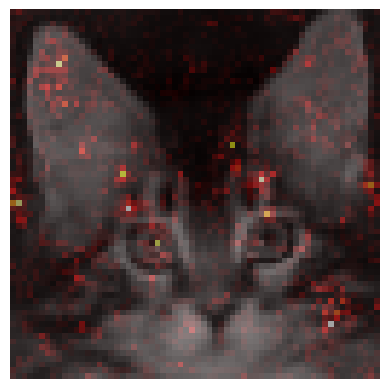

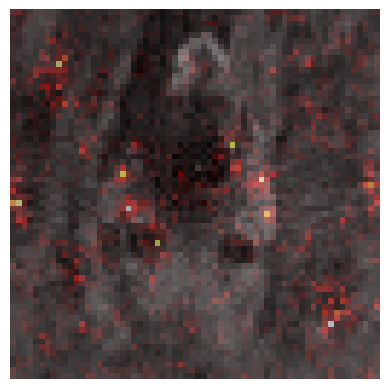

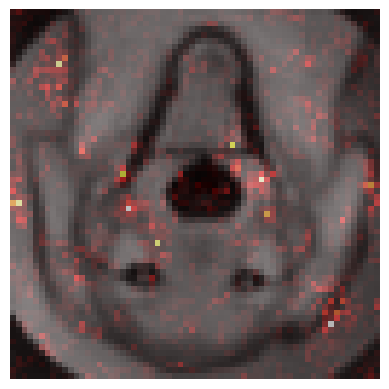

array([74,  6, 26, 14, 41, 14, 18, 62, 20, 30])

In [41]:
for i in np.random.randint(0, 100, size=10):
    plot_grayscale_importance_image(augmented_images[i], feature_importance_ada)
np.random.randint(0, 100, size=10)

Adaboost analysis reveals a heavier reliance on a select few features, notably emphasizing regions such as the eyes and the left ear in the image. Despite this focus, the highlighted features consistently exhibit the characteristic patterns indicative of a cat.

Remarkably, Adaboost's utilization of a weighted combination of weak learners allows it to emphasize the most informative features while still capturing the essential visual cues associated with feline morphology.



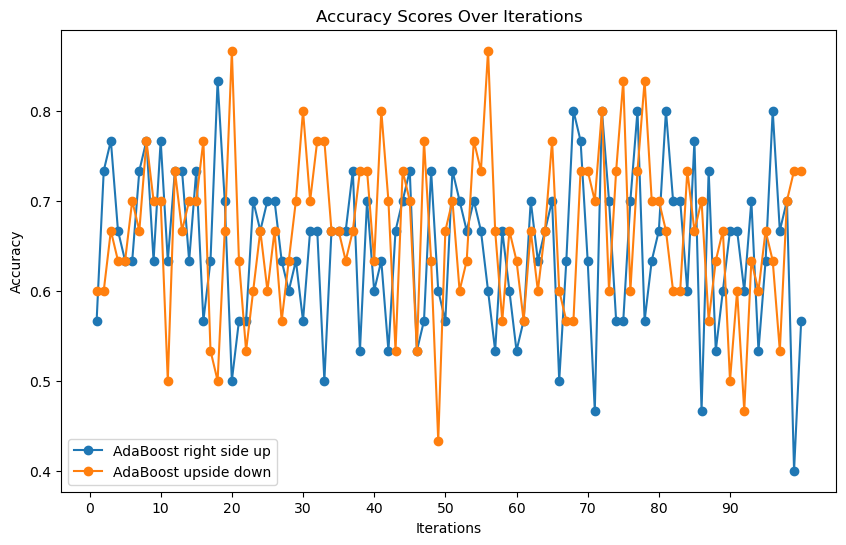

0.6756666666666667
0.6759999999999999


In [46]:
# plot accuracy bias.
plot_model_accuracy(accuracy_rsu_ada ,accuracy_usd_ada, "AdaBoost")
print(np.mean(accuracy_usd_logistic))
print(np.mean(accuracy_rsu_logistic))

Evaluation of the Adaboost classifier similarly reveals a lack of significant bias in distinguishing between upside-down and right-side-up images. This unbiased classification tendency is a testament to Adaboost's adaptability and feature selection prowess. Through its iterative boosting technique, Adaboost focuses on refining its understanding of critical image characteristics, effectively mitigating biases and ensuring reliable predictions across various orientations.






